# **1. Cut Sinyal**

In [6]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, welch
from pywt import wavedec
from scipy.stats import skew, kurtosis

In [7]:
input_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/input"
output_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

file_list = glob.glob(os.path.join(input_dir, '*.csv'))

for file_name in file_list:
    df = pd.read_csv(file_name)
    fs = 128
    duration = 30  # in seconds
    samples_per_duration = fs * duration
    n_samples = len(df)
    n_parts = n_samples // samples_per_duration
    remainder = n_samples % samples_per_duration

    for i in range(n_parts):
        start_idx = i * samples_per_duration
        end_idx = (i + 1) * samples_per_duration
        part_df = df[start_idx:end_idx]
        part_file_name = os.path.join(output_dir, f"{os.path.basename(file_name)[:-4]}_part{i+1}.csv")
        part_df.to_csv(part_file_name, index=False)
    
    if remainder > 0:
        remainder_df = df[-remainder:]
        remainder_file_name = os.path.join(output_dir, f"{os.path.basename(file_name)[:-4]}_remainder.csv")
        remainder_df.to_csv(remainder_file_name, index=False)


# **2. Filtering : BandPass**

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=50):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    filter_coeffs = signal.firwin(order, [low, high], pass_zero=False)
    b = filter_coeffs
    a = 1
    return b, a

def apply_bandpass_filter(df, channels, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    for channel in channels:
        data = df[channel].values
        filtered_data = signal.filtfilt(b, a, data)
        df[channel] = filtered_data
    return df


In [10]:
lowcut = 1 
highcut = 47 
fs = 128 

# Set up directory path to CSV files
input_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/output"
output_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/filtered"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
file_list = glob.glob(os.path.join(input_dir, "*.csv"))

for filename in file_list:
    df = pd.read_csv(filename)
    channels_to_filter = list(df.columns)
    df_filtered = apply_bandpass_filter(df, channels_to_filter, lowcut, highcut, fs)
    new_filename = os.path.basename(filename).split(".csv")[0] + "_filtered.csv" 
    new_file_path=os.path.join(output_dir,new_filename)
    df_filtered.to_csv(new_file_path, index=False)

# **3. Band Power**

In [11]:
def extract_band_power(eeg_data, fs, band, level):
    coeffs = wavedec(eeg_data, 'db4', level=level)
    cA = coeffs[level]
    f, Pxx = welch(cA, fs, nperseg=min(256, len(cA)))
    
    freq_bands = {'delta': [0.5, 4],
                  'theta': [4, 8],
                  'alpha': [8, 13],
                  'beta': [13, 30],
                  'gamma': [30, 45]}
    
    freq_ix = {'delta': np.logical_and(f >= freq_bands['delta'][0], f < freq_bands['delta'][1]),
               'theta': np.logical_and(f >= freq_bands['theta'][0], f < freq_bands['theta'][1]),
               'alpha': np.logical_and(f >= freq_bands['alpha'][0], f < freq_bands['alpha'][1]),
               'beta': np.logical_and(f >= freq_bands['beta'][0], f < freq_bands['beta'][1]),
               'gamma': np.logical_and(f >= freq_bands['gamma'][0], f < freq_bands['gamma'][1])}
    
    mask = freq_ix[band]
    band_power = np.trapz(y=Pxx[mask], x=f[mask])
    
    return band_power

In [12]:
def extract_band_powers(filename):
    df = pd.read_csv(filename)
    
    fs = 128
    level = 4
    channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    
    band_powers = {}
    for channel in channels:
        channel_powers = {}
        for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
            band_power = extract_band_power(df[channel].values, fs, band, level)
            channel_powers[band] = band_power
        band_powers[channel] = channel_powers      
    return band_powers

In [14]:
# Set up directory paths
input_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/filtered"
output_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/power"

channel_dfs = []
for filename in glob.glob(os.path.join(input_dir, "*.csv")):
    band_powers = extract_band_powers(filename)
    for channel in band_powers:
        channel_powers = band_powers[channel]
        channel_powers['channel'] = channel
        channel_powers['filename'] = os.path.basename(filename)
        channel_powers = pd.DataFrame.from_dict(channel_powers, orient='index').T
        channel_dfs.append(channel_powers)
df = pd.concat(channel_dfs)
df.to_csv(os.path.join(output_dir, 'band_power.csv'), index=False)

## 3.1 Plotting Band Power

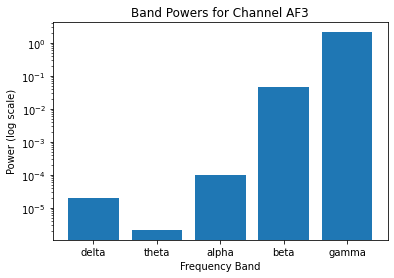

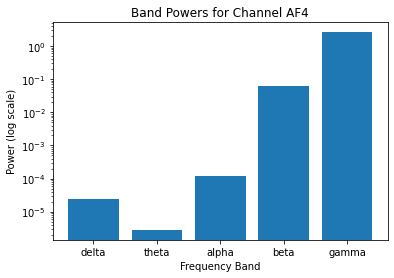

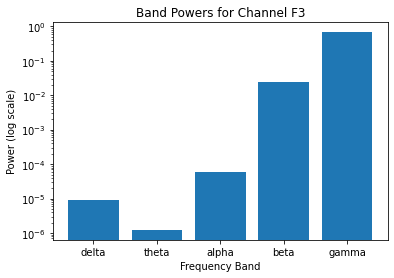

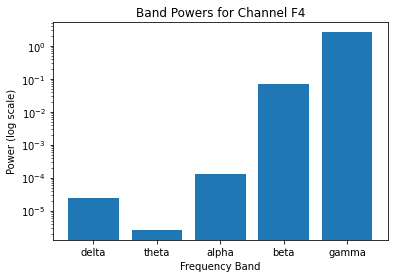

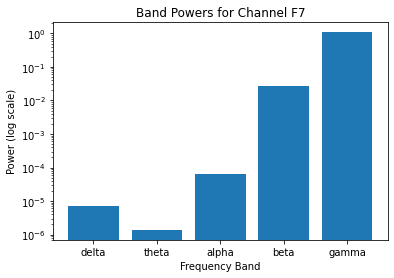

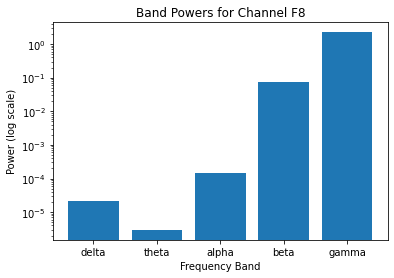

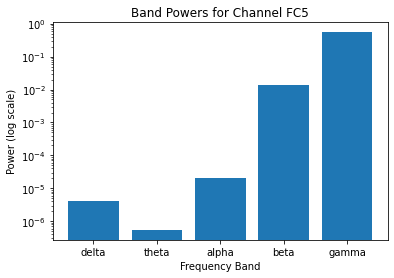

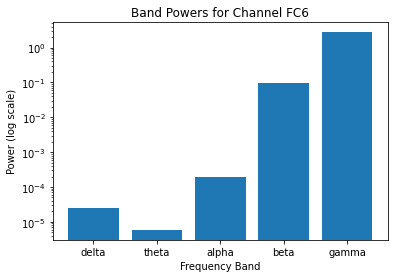

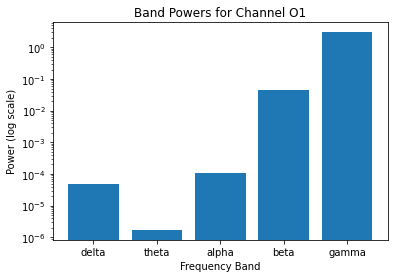

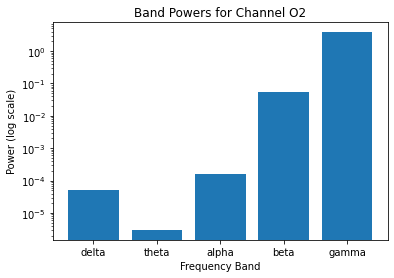

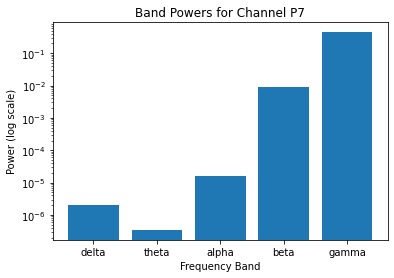

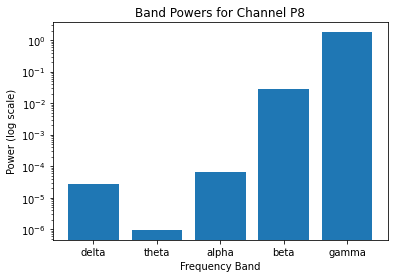

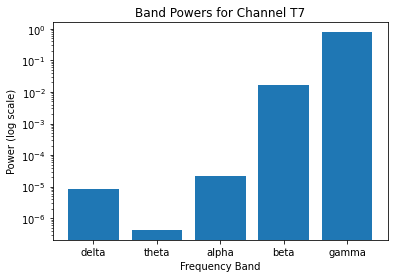

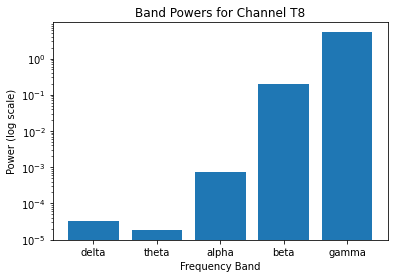

In [16]:
band_powers = extract_band_powers('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/filtered/adit_part1_filtered.csv')


for channel in band_powers:
    freq_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    powers = [max(band_powers[channel][band], 1e-10) for band in freq_bands]  
    
 
    plt.figure()
    plt.bar(freq_bands, powers)
    plt.title(f"Band Powers for Channel {channel}")
    plt.xlabel("Frequency Band")
    plt.ylabel("Power (log scale)")
    plt.yscale('log')  
    plt.show()




# **4. Statistical**

In [17]:
# define function for feature extraction
def extract_features(data):
    # compute statistical features
    mean = np.mean(data)
    std = np.std(data)
    var = np.var(data)
    rms = np.sqrt(np.mean(np.square(data)))
    skewness = skew(data)
    kurt = kurtosis(data)
    # return features as dictionary
    features = {'mean': mean, 'std': std, 'var': var, 'rms': rms, 'skewness': skewness, 'kurtosis': kurt}
    return features


In [18]:
input_folder = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/filtered"
output_folder ="D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/statistical"

files = glob.glob(os.path.join(input_folder, '*.csv'))

In [19]:
for file in files:
   
    df = pd.read_csv(file)
    channels = df.columns.tolist()
    for channel in channels:
        data = df[channel].values
        features = extract_features(data)
        channel_folder = os.path.join(output_folder, channel)
        if not os.path.exists(channel_folder):
            os.makedirs(channel_folder)
        output_file = os.path.join(channel_folder, os.path.basename(file).replace('.csv', '_{}_features.csv'.format(channel)))
        pd.DataFrame(features, index=[0]).to_csv(output_file, index=False)

Print Dataframe statistical

In [20]:
file_list = glob.glob('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/statistical/AF3/*.csv')
df_list = []

for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)
    
merged_df = pd.concat(df_list, axis=0, ignore_index=True)
merged_df


,mean,std,var,rms,skewness,kurtosis
0,1621.408993,10.256329,105.192290,1621.441432,-0.155745,0.423581
1,1618.755163,12.616542,159.177124,1618.804328,-1.093175,2.617289
2,1618.032234,11.690741,136.673431,1618.074468,-0.547335,1.339881
3,1623.431925,11.250719,126.578672,1623.470910,-0.088485,1.404841
4,1614.060860,81.645789,6666.034885,1616.124529,-1.021292,9.714070
...,...,...,...,...,...,...
71,1635.511765,21.285639,453.078440,1635.650272,0.102826,0.998683
72,1632.550837,51.521716,2654.487234,1633.363622,1.939471,7.130819
73,1648.068694,62.289525,3879.984938,1649.245405,2.151028,9.058606
74,1639.757592,81.356175,6618.827222,1641.774585,0.920032,3.638376


In [22]:
file_list = glob.glob('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/statistical/AF3/*.csv')
df_list = []

for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

merged_df = pd.concat(df_list, axis=0, ignore_index=True)
output_file = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/dataframe/AF3/mergedaf3_statistical.csv'
merged_df.to_csv(output_file, index=False)

print(merged_df)


           mean        std          var          rms  skewness  kurtosis
0   1621.408993  10.256329   105.192290  1621.441432 -0.155745  0.423581
1   1618.755163  12.616542   159.177124  1618.804328 -1.093175  2.617289
2   1618.032234  11.690741   136.673431  1618.074468 -0.547335  1.339881
3   1623.431925  11.250719   126.578672  1623.470910 -0.088485  1.404841
4   1614.060860  81.645789  6666.034885  1616.124529 -1.021292  9.714070
..          ...        ...          ...          ...       ...       ...
71  1635.511765  21.285639   453.078440  1635.650272  0.102826  0.998683
72  1632.550837  51.521716  2654.487234  1633.363622  1.939471  7.130819
73  1648.068694  62.289525  3879.984938  1649.245405  2.151028  9.058606
74  1639.757592  81.356175  6618.827222  1641.774585  0.920032  3.638376
75  1610.088068  79.658300  6345.444681  1612.057391  0.902170  0.657760

[76 rows x 6 columns]


In [21]:
# ## PAKE INI BUAT MERGED

# def merge_csv_files(input_folder, output_file):
#     file_list = glob.glob(input_folder + '/*.csv')
#     df_list = []
#     for file in file_list:
#         df = pd.read_csv(file)
#         df_list.append(df)
#     merged_df = pd.concat(df_list, axis=0, ignore_index=True)
#     merged_df.to_csv(output_file, index=False)


# input_folder = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/statistical/AF3'
# output_file = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/dataframe/AF3/merged_statistical_AF3.csv'
# merge_csv_files(input_folder, output_file)


# **5. Entropy**

In [23]:
input_dir = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/filtered'
output_dir = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/entropy/'

win_size = 256
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'): 
        eeg_data = np.loadtxt(os.path.join(input_dir, filename), delimiter=',',skiprows=1)
        for channel_idx in range(eeg_data.shape[1]):
            channel_data = eeg_data[:, channel_idx]
            f, psd = signal.welch(channel_data, fs=128, window='hann', nperseg=win_size, noverlap=win_size//2)
            norm_psd = psd / np.sum(psd)
            entropy = -np.sum(norm_psd * np.log2(norm_psd)) / np.log2(norm_psd.size)
            channel_name = f'channel_{channel_idx+1}'
            output_path = os.path.join(output_dir, channel_name)
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            output_filename = os.path.splitext(filename)[0] + '_' + channel_name + '.csv'
            output_file = os.path.join(output_path, output_filename)
            np.savetxt(output_file, [entropy], delimiter=',')


Buat Gabung hasil entropy

In [25]:
file_list = glob.glob('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/entropy/channel_11/*.csv')
merged_df = pd.DataFrame()

for file in file_list:
    df = pd.read_csv(file)
    merged_df = pd.concat([merged_df, df], axis=0)

merged_df = merged_df.reset_index(drop=True)

output_file = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/dataframe/FC6/merged12_entropy.csv'
merged_df.to_csv(output_file, index=False)
merged_df

,7.890091044945446441e-01,7.082881704863411843e-01,7.458991538269507116e-01,7.858375320811271658e-01,5.312956418802800007e-01,5.343162399417985542e-01,5.766654787022857942e-01,7.133744107104860177e-01,6.490547382225226869e-01,7.146760250738262155e-01,...,8.450616673533096757e-01,6.572461322569597142e-01,5.754715736104468737e-01,7.012280068102634267e-01,6.301330907972262363e-01,6.115025905248099303e-01,6.851112666048653210e-01,6.586302884102374078e-01,5.144551328953125280e-01,6.497068704574648912e-01


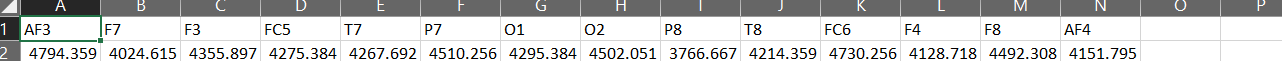